In [ ]:
import torchmetrics
import sys
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, ConcatDataset
from neuroforest.dataset import image_loader
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, TensorDataset
from livelossplot import PlotLosses

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"




Loading data from : C:\Users\kupec\OneDrive\Desktop\neuroforest-main\data_2022\trajectories_processed
Loading data from : C:\Users\kupec\OneDrive\Desktop\neuroforest-main\data_2024\trajectories_processed
<class 'neuroforest.dataset.ImageLoader'>


In [ ]:
def filter(image_loader, category):
    """
    Retourne un sous-ensemble de image_loader ne contenant que les images de la catégorie category
    
    Args:
        image_loader: image_loader
        category: str, catégorie d'impression : avec ou sans champignon, avec ou sans timestamp
    
    Return:
        Subset: sous-ensemble de image_loader
    """
    indices = []
    for i in range(len(image_loader)):
        if image_loader.get_category(i) == category:
            indices.append(i)
    return Subset(image_loader, indices)

def get_data_augmentation_transforms():
    return transforms.Compose([
        transforms.RandomRotation(degrees=(-30, 30)),  # Rotation aléatoire
        transforms.RandomHorizontalFlip(),              # Flip horizontal
        transforms.Resize((128, 128)),                  # Redimensionner les images
        #transforms.ToTensor(),                          # Conversion en tenseur
    ])


def create_train_test_split(image_set, test_size = 0.2):
    dataset_size = len(image_set)
    test_size = int(test_size * dataset_size)
    train_size = dataset_size - test_size
    
    return random_split(image_set, [train_size, test_size])

def augment_dataset(dataset, augmentation_factor, transform):
    augmented_datasets = []

    for _ in range(augmentation_factor):
        augmented_data = [(transform(data), label) for data, label in dataset]
        augmented_datasets.append(augmented_data)

    # Concaténer tous les datasets augmentés en un seul
    return ConcatDataset([augmented_data for augmented_data in augmented_datasets])

def create_dataloader(dataset, batch_size=32, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)



filtered_set = filter(image_loader, 'with_mushroom_with_timestamp') 
train, test = create_train_test_split(filtered_set, 0.2)

aug_train = augment_dataset(train, 5, get_data_augmentation_transforms())
aug_test = augment_dataset(test, 5, get_data_augmentation_transforms())

train_loader = create_dataloader(aug_train)
test_loader = create_dataloader(aug_test)

# image_loader : liste des images : liste de tuples (image, label)
# L'image est un tenseur de taille (3, 128, 128) (3 canaux, 128x128 pixels)
# Le label est un dictionnaire avec les clés suivantes : 'sujet', 'Name', 'Q1.1'....

# filtered_set : liste ne retenant que les images de la catégorie d'impression sélectionnée
# train, test : split du dataset en train et test
# aug_train, aug_test : dataset augmenté (facteur 5)

In [ ]:
def calculate_score(labels):
    """
    Calcule le score ASRS pour chaque individu

    Args:
        labels: dict, labels d'un batch
    
    Returns:
        score_final: list, score ASRS pour chaque individu
        
    """
    score_keys = ['asrs1', 'asrs2', 'asrs3', 'asrs4', 'asrs5', 'asrs6', 'asrs7', 'asrs8', 'asrs9', 'asrs10', 'asrs11', 'asrs12', 'asrs13', 'asrs14', 'asrs15', 'asrs16', 'asrs17', 'asrs18']
    score_final = []
    for i in range(int(len(labels["Name"]))):
        score = sum(int(labels[key][i]) for key in score_keys)
        score_final.append(score)
    return score_final



{'sujet': ['15', '11', '22', '4', '32', '35', '17', '7', '36', '35', '29', '29', '15', '29', '35', '32', '36', '12', '22', '35', '15', '22', '15', '9', '12', '17', '15', '11', '7', '7', '12', '22'], 'Name': ['Alice', 'abdelmoumen', 'Tiffany', 'Richard', 'Ilian', 'Jeanne1', 'Asma', 'Antoine', 'Clara', 'Jeanne1', 'Kurshidh', 'Kurshidh', 'Alice', 'Kurshidh', 'Jeanne1', 'Ilian', 'Clara', 'maxime', 'Tiffany', 'Jeanne1', 'Alice', 'Tiffany', 'Alice', 'gouwy', 'maxime', 'Asma', 'Alice', 'abdelmoumen', 'Antoine', 'Antoine', 'maxime', 'Tiffany'], 'Q1.1': ['b', 'a', 'a', 'b', 'a', 'b', 'b', 'b', 'b', 'b', 'a', 'a', 'b', 'a', 'b', 'a', 'b', 'b', 'a', 'b', 'b', 'a', 'b', 'a', 'b', 'b', 'b', 'a', 'b', 'b', 'b', 'a'], 'Q1.2.1': ['2', '2', '5', '3', '5', '2', '5', '4', '4', '2', '3', '3', '2', '3', '2', '5', '4', '4', '5', '2', '2', '5', '2', '5', '4', '5', '2', '2', '4', '4', '4', '5'], 'Q1.2.2': ['3', '3', '5', '4', '5', '4', '5', '4', '5', '4', '4', '4', '3', '4', '4', '5', '5', '4', '5', '4', '3',

### Defining the SimpleCNN

In [30]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size = 4, stride=4, padding=0)
        self.fc1 = nn.Linear(24 * 2 * 2, 1)
        #self.fc2 = nn.Linear(64, 1)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 24 * 2 * 2)
        x = self.fc1(x)
        #x = self.fc2(x)
        x = 53*F.sigmoid(x)
        return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

for batch, label in train_loader:
    label = torch.tensor(calculate_score(label)).float()
    batch, label = batch.to(device), label.to(device)
    output = model(batch)
    print(output.flatten())
    print(label)
    print(F.mse_loss(output, label))
    break
for batch, label in test_loader:
    label = torch.tensor(calculate_score(label)).float()
    batch, label = batch.to(device), label.to(device)
    output = model(batch)
    print(output.flatten())
    print(label)
    print(F.mse_loss(output, label))
    break

print(len(train_loader.dataset))


tensor([32.0271, 32.0155, 32.0638, 32.0408, 32.0206, 32.0470, 31.9959, 32.0464,
        32.0296, 32.0543, 32.0379, 31.9895, 32.0424, 32.0500, 32.0390, 31.9989,
        32.0261, 31.9958, 32.0069, 32.0348, 32.0521, 32.0216, 32.0315, 32.0554,
        32.0292, 32.0228, 32.0489, 32.0023, 32.0398, 32.0193, 32.0117, 32.0128],
       grad_fn=<ViewBackward0>)
tensor([32.,  4., 40., 32., 26., 31., 33., 10., 33., 23., 35., 49., 31., 22.,
        29., 26., 46., 45., 26., 46., 23., 26., 26., 48., 36., 46., 19., 49.,
        32., 37., 33., 34.])
tensor(112.5566, grad_fn=<MseLossBackward0>)
tensor([32.0326, 32.0356, 32.0204, 32.0384, 31.9957, 32.0131, 32.0525, 32.0285,
        32.0413, 32.0256, 32.0279, 31.9906, 32.0344, 32.0377, 32.0556, 31.9819,
        32.0398, 32.0471, 32.0348, 32.0397, 32.0330, 32.0361, 32.0320, 32.0155,
        32.0678, 32.0645, 32.0371, 32.0028, 32.0416, 32.0142, 32.0716, 32.0468],
       grad_fn=<ViewBackward0>)
tensor([21., 24., 29., 23., 29., 34., 26., 45., 36., 34., 20., 2

C:\Users\kupec\AppData\Local\Temp\ipykernel_4924\3891846844.py:10: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print(F.mse_loss(output, label))
C:\Users\kupec\AppData\Local\Temp\ipykernel_4924\3891846844.py:18: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print(F.mse_loss(output, label))


### Training pipeline

In [ ]:
def training_pipeline(model, num_epochs = 5,train_loader = train_loader, test_loader = test_loader, device = device):
    """
    Entraîne un modèle de réseau de neurones sur un jeu de données
    
    Args:
        model: nn.Module, modèle de réseau de neurones
        num_epochs: int, nombre d'époques
        train_loader: DataLoader, chargeur de données d'entraînement
        test_loader: DataLoader, chargeur de données de test
        device: str, 'cpu' ou 'cuda'
    """  
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    # Initialisation de livelossplot
    liveloss = PlotLosses()

    # Boucle d'entraînement
    for epoch in range(num_epochs):
        logs = {}  # Stocke les pertes pour chaque époque

        # Étape d'entraînement
        model.train()
        train_running_loss = 0.0
        for images, labels in train_loader:
            labels = torch.tensor(calculate_score(labels)).float()
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images).flatten()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()

        logs['loss'] = train_running_loss / len(train_loader.dataset)

        # Étape de validation
        model.eval()
        test_running_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                labels = torch.tensor(calculate_score(labels)).float()
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images).flatten()
                loss = criterion(outputs, labels)
                test_running_loss += loss.item()

        logs['val_loss'] = test_running_loss / len(test_loader.dataset)

        # Mise à jour des graphiques en temps réel
        liveloss.update(logs)
        liveloss.send()

        # Affichage des logs
        print(f"Epoch {epoch+1}/{num_epochs} - loss: {logs['loss']:.4f} - val_loss: {logs['val_loss']:.4f}")


### Define SimpleCNN_classes
A classifying task rather than a regressor

In [ ]:
class SimpleCNN_classes(nn.Module):
    """
    Modèle de réseau de neurones convolutif simple pour la classification

    Args:
        nn.Module: classe de base pour tous les modules de réseau de neurones
    """
    def __init__(self):
        super(SimpleCNN_classes, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size = 4, stride=4, padding=0)
        self.fc1 = nn.Linear(16 * 2 * 2, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16 * 2 * 2)
        x = self.fc1(x)
        return x

def get_classes(scores, num_classes = 4):
    """
    Détermine la classe d'un score ASRS
    
    Args:
        scores: list, scores ASRS
        num_classes: int, nombre de classes
    
    Returns:
        torch.tensor, classes
    """
    classes = []
    for score in scores:
        if score < 20:
            classes.append(torch.tensor(0))
        elif score < 30:
            classes.append(torch.tensor(1))
        elif score < 40:
            classes.append(torch.tensor(2))
        else:
            classes.append(torch.tensor(3))
    return torch.tensor(classes, dtype = torch.long)

def training_pipeline_class(model, num_epochs = 5,train_loader = train_loader, test_loader = test_loader, device = device):  
    """
    Entraîne un modèle de réseau de neurones sur un jeu de données
    
    Args:
        model: nn.Module, modèle de réseau de neurones
        num_epochs: int, nombre d'époques
        train_loader: DataLoader, chargeur de données d'entraînement
        test_loader: DataLoader, chargeur de données de test
        device: str, 'cpu' ou 'cuda'
    
    
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    # Initialisation de livelossplot
    liveloss = PlotLosses()

    # Boucle d'entraînement
    for epoch in range(num_epochs):
        logs = {}  # Stocke les pertes pour chaque époque

        # Étape d'entraînement
        model.train()
        train_running_loss = 0.0
        for images, labels in train_loader:
            labels = get_classes(torch.tensor(calculate_score(labels)).float())
            images, labels = images.to(device), labels
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()

        logs['loss'] = train_running_loss / len(train_loader.dataset)

        # Étape de validation
        model.eval()
        test_running_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                labels = get_classes(torch.tensor(calculate_score(labels)).float())
                images, labels = images.to(device), labels.to(device)
                
                outputs =model(images)
                
                loss = criterion(outputs, labels)
                test_running_loss += loss.item()

        logs['val_loss'] = test_running_loss / len(test_loader.dataset)

        # Mise à jour des graphiques en temps réel
        liveloss.update(logs)
        liveloss.send()

        # Affichage des logs
        print(f"Epoch {epoch+1}/{num_epochs} - loss: {logs['loss']:.4f} - val_loss: {logs['val_loss']:.4f}")


### Train SimpleCNN_classes

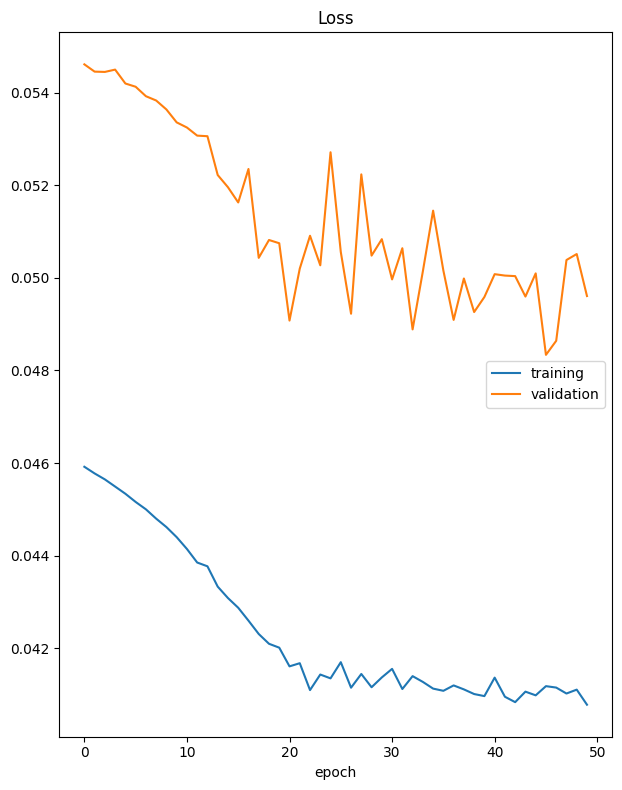

Loss
	training         	 (min:    0.041, max:    0.046, cur:    0.041)
	validation       	 (min:    0.048, max:    0.055, cur:    0.050)
Epoch 50/50 - loss: 0.0408 - val_loss: 0.0496


In [120]:
model = SimpleCNN_classes().to(device)
for batch, labels in train_loader:
    images = batch.to(device)
    outputs = model(images).flatten()
    print(outputs)
training_pipeline_class(model, num_epochs = 50)